![SimPy](http://simpy.readthedocs.io/en/latest/_static/simpy-logo-small.png) 

In [13]:
import simpy

## Short introduction to SimPy

### What is SimPy

SimPy is a _process-based discrete-event simulation **framework**_ for Python.

Other _discrete-events_ software are NS3, NetSim and many others.

### Simulators basics

Three basic ways to simulate a series of inter-dependent events are:

  - Activity oriented: simulate each small time steps
  - Event oriented: ignore the time in between events (discrete-events).
  - Process based: each activity is simulated as a UNIX process, taking advantage of queues, threads etc. offered by the OS.
  
  > SimPy is process-based, but it does not used threads, it instead employs Python _generators_.

## Example

An example of events which can be simulated on SimPy is a voice call on a circuit switch network:

 - First the load (voice calls) is generated
 - Than a limit to the available resources is imposed, with the aim to measure systems capabilities

### Setup

In [14]:
import random

def expo_delay(mean):
    return random.expovariate(1/mean)

def poisson_arrival(arrival):
    shape = 1
    return random.gammavariate(shape, arrival)

# Assume number of users and tyical traffic per user for voice call
nUsers = 31
User_Traffic_Erlangs = 0.1  # Traffic per user in PSTN (typical)

# Calculate total traffic generate by those users
BH_Erlangs = nUsers * User_Traffic_Erlangs  # Traffic [Erlangs] - dimensioneless

# Assume some duratin for each call (average)
mean_call_duration = 180  # Mean Holding Time (MHT) [sec]

# Calculate the Call Attempt/Arrival for the given traffic (not users!)
BHCA = BH_Erlangs / mean_call_duration # calls attempt during Busy Hour [call/sec]

# This is the average time between calls you should expect
rate_arrival = 1 / BHCA # [sec/call]
print("Busy Hour Traffic: {e}Erlangs (equivalent to {e}hours of call every hour)".format(
        e=BH_Erlangs))
print("Call rate of arrival: {r:.2f}sec/call".format(r=rate_arrival))

Busy Hour Traffic: 3.1Erlangs (equivalent to 3.1hours of call every hour)
Call rate of arrival: 58.06sec/call


In [15]:
import statistics as stats
A = [poisson_arrival(rate_arrival) for i in range(1,1000)]
print("Rate Arrival:  Required: {a:=3.4f}sec/call, Mean {m:=3.4f}sec/call".format(
        a=rate_arrival, 
        m=stats.mean(A)))
D = [expo_delay(mean_call_duration) for i in range(1,1000)]
print("Call Duration: Required: {d:=.4f}sec, Mean {m:=.4f}sec".format(d=mean_call_duration, 
                                                                  m=stats.mean(D)))

Rate Arrival:  Required: 58.0645sec/call, Mean 60.3261sec/call
Call Duration: Required: 180.0000sec, Mean 178.6277sec


### Simulation

Assuming calls are always served (e.g. _resources >> offered traffic_).

Two processes are created representing a typical voice call:
 * _ringring_: alerts of a new call for a user (arrival time is a random process).
 * _talk_: the user talks for a random period before terminating the call. 
 
A _Monitor_ global variable can be used to store variable to be monitored. Note that a python list or any other _change in place_ container must be used; such that all processes have access to it.

In [17]:
def talk(env, call_id):
    """ 
    User locks resources for the duration of the call. 
    """  
    yield env.timeout(expo_delay(mean_call_duration))  # wait to terminate call
    monitor_talk(env.now, call_id)  # Logging event
    return True
    
def ringring(env):
    """
    Call arrival
    """
    call_id = 0
    while True:
        env.process(talk(env, call_id))  # Call 'talk process'
        monitor_ring(env.now, call_id)  # logging event
        yield env.timeout(poisson_arrival(rate_arrival))  # wait to next call
        call_id = call_id + 1

In [25]:
""" Use a list to store process' states """
Monitor=[]

# append to Monitor string to print 
def monitor_talk(t, id):
    """ Apppend call termination to log"""
    Monitor.append("t={t:=7.2f}s - User {id:>3d} has terminated the call".format(t=t, 
                                                                           id=id))
def monitor_ring(t, id):
    """ Append ring to log"""
    Monitor.append("t={t:=7.2f}s - {ring} for user {id:>3d}".format(t=t,
                    ring="\033[1;30;41mRing Ring\033[0m", id=id))    

""" SimPy calls to create and environement and start process """
env = simpy.Environment()
env.process(ringring(env))
env.run(60 * 10)  # simulate 10min calls

# print some calls
[print(m) for m in Monitor]
print("\t...\t...\t...")

t=   0.00s - Ring Ring for user   0
t=  48.14s - Ring Ring for user   1
t=  98.36s - User   0 has terminated the call
t= 141.46s - User   1 has terminated the call
t= 179.72s - Ring Ring for user   2
t= 242.78s - User   2 has terminated the call
t= 306.76s - Ring Ring for user   3
t= 339.98s - Ring Ring for user   4
t= 397.37s - Ring Ring for user   5
t= 439.18s - User   4 has terminated the call
t= 559.34s - User   3 has terminated the call
	...	...	...


### A more realistic example: finite resources

Let's assume some finite resources: the system only provide a maximum number of lines/channels, above which no further calls can be served.

SimPy's _Container_ utility are used to pass the number of lines among the _talk_ processes.

In [49]:
'''Set up resources'''
NUMBER_LINES= 8

def talk(env, channels, Log):
    ''' Generator for channel usage
        Only assign channels if there are any available
    '''
    if channels.level > 0:  # check channel avaiability
        channels.get(1)  # take a line
        yield env.timeout(expo_delay(mean_call_duration))
        channels.put(1)  # free up a line
    else:
        # no resources available... drop the call
        Log.append('drop')
    return True
    
def call_arrival(env, channels, Log):
    ''' Generator for call arrival
        For every new call, call the _talk_ process to serve the call'''
    while True:
        Log.append('call')
        env.process(talk(env, channels, Log))
        yield env.timeout(poisson_arrival(rate_arrival))
        # log status of channels
        Monitor.append((env.now, channels.level))
    
'''Set up log stores'''
Log = []  # store call events
Monitor = []  # store usage of channels

''' Start SimPy by creating environment and the container for resources'''
env = simpy.Environment()
# The container is passed to all the processes
channels = simpy.Container(env, capacity=NUMBER_LINES, init=NUMBER_LINES)
env.process(call_arrival(env, channels, Log))
env.run(60 * 60 * 1000) 

#### Results

Number calls generated: 61860
Number dropped calls: 580
Call blocking 0.0094


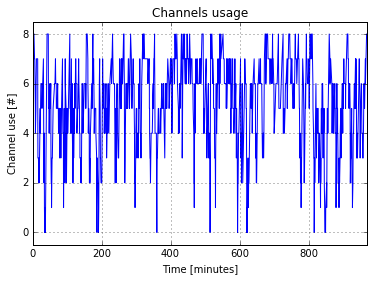

In [50]:
%matplotlib inline

ncalls = sum(1 for e in Log if e == 'call')
ndrop = sum(1 for e in Log if e == 'drop')
print("Number calls generated: {n}".format(n=ncalls))
print("Number dropped calls: {d}".format(d=ndrop))
print("Call blocking {r:2.4f}".format(r=ndrop/ncalls), )

import matplotlib.pyplot as plt

MAX_SMPL = 1000
t = [m[0]/60 for m in Monitor[:MAX_SMPL]]
M = [m[1] for m in Monitor[:MAX_SMPL]]
plt.plot(t,M,'-')
plt.xlabel('Time [minutes]')
plt.ylabel('Channel use [#]')
plt.title('Channels usage')
plt.axis([0,t[-1],-0.5,8.5])
plt.grid(True)
plt.show(True)

#### Disclaimer
The example above only shows a simple case of a classical _M/M/k_ problem; in practice the final result can be calculated from equation (see [Erlang-B](https://en.wikipedia.org/wiki/Erlang_(unit)) on Wikipedia), no simulation is actually needed! 

In [54]:
import math
def Blocking_Prob(E, m):
    """ Calculate probability of blocking for Erlangs distribution B(E,m)"""
    # note this algorithm is not numerically stable... bit rubbish really!
    return ((E**m)/math.factorial(m))/sum((E**i)/math.factorial(i) for i in range(0,m))

print("Theoretical drop rate: {d:.4f}".format(d=Blocking_Prob(BH_Erlangs, NUMBER_LINES)))

Theoretical drop rate: 0.0101


## Further enhancements 